In [1]:
%matplotlib inline
import nba_py as nba
from nba_py import player
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import math

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

/Users/andrewzhuang/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [57]:
df = pd.read_csv('july_25.csv')
del df['Unnamed: 0']

In [61]:
df_1 = pd.read_csv('temp2_deletethis2.csv')
del df_1['Unnamed: 0']
df_1.columns = df_1.iloc[0]
df_1 = df_1.reindex(df.index.drop(0))
# df_1 = df_1.dropna()
df['PERSON_ID'] = df['PERSON_ID'].astype(str)
len(df_1)

9561

In [62]:
df = pd.merge(df, df_1, how='left', on='PERSON_ID')

In [96]:
for col in df.columns.values:
    df[col] = df[col].fillna(-1)

In [97]:
df['WEIGHT'] = df['WEIGHT'].astype(int)

to_num = ['AOP_FGA','AOP_FG_PCT','Bank_FGA','Bank_FG_PCT','DUNK_FGA','DUNK_FG_PCT',
'FADE_FGA','FADE_FG_PCT','FGR_FGA','FGR_FG_PCT','HOOK_FGA','HOOK_FG_PCT',
'JS_FGA','JS_FG_PCT','LAY_FGA','LAY_FG_PCT','TIP_FGA','TIP_FG_PCT']

for col in to_num:
    df[col] = df[col].astype(float)

In [100]:
def ft_to_cm(x):
    if str(x) == '-1':
        return (float(-1))
    else:
        return (float(float(x[0])*30.48 + float(x[2:])*2.54))
df['HEIGHT'] = df['HEIGHT'].apply(ft_to_cm)

In [84]:
def col_dict(unique_vals):
    my_dict = {}
    count = 0
    for val in unique_vals:
        my_dict[val] = count
        count += 1
    return (my_dict)
    
def to_cat(my_dict, x):
    return my_dict[x]

cat_features = ['SCHOOL','POSITION']
for fet in cat_features:
    df[fet] = df[fet].apply(lambda x: to_cat(col_dict(df[fet].unique()),x))

In [138]:
df['CT_FG_PCT_DIFF'] = df['FG_PCT'] - df['CT_FG_PCT']

In [115]:
for col in df.columns:
    print (col)

FG_PCT
FG3_PCT
FT_PCT
OREB
DREB
REB
AST
TOV
STL
BLK
4Q_FG_PCT
4Q_FG3_PCT
4Q_FT_PCT
4Q_OREB
4Q_DREB
4Q_REB
4Q_AST
4Q_TOV
4Q_STL
4Q_BLK
PO_FG_PCT
PO_FG3_PCT
PO_FT_PCT
PO_OREB
PO_DREB
PO_REB
PO_AST
PO_TOV
PO_STL
PO_BLK
SC_FG_PCT
SC_FG3_PCT
SC_FT_PCT
SC_OREB
SC_DREB
SC_REB
SC_AST
SC_TOV
SC_STL
SC_BLK
PERSON_ID
SEASON_ID
GP
GS
AVG_MIN
AGE
SEASON
RA_FGA
RA_FG_PCT
P_FGA
P_FG_PCT
MR_FGA
MR_FG_PCT
LC_FGA
LC_FG_PCT
RC_FGA
RC_FG_PCT
ATB_FGA
ATB_FG_PCT
BC_FGA
BC_FG_PCT
total_shot_attempts
RA_FQ
P_FQ
MR_FQ
LC_FQ
RC_FQ
ATB_FQ
BC_FQ
0D_FQ
0D_FG_PCT
1D_FQ
1D_FG_PCT
2D_FQ
2D_FG_PCT
3D_FQ
3D_FG_PCT
VT_FQ
VT_FG_PCT
T_FQ
T_FG_PCT
O_FQ
O_FG_PCT
WO_FQ
WO_FG_PCT
CT_W_PCT
CT_FG_PCT
CT_FGA
CT_FG3_PCT
CT_FG3A
CT_FT_PCT
AOP_FGA
AOP_FG_PCT
Bank_FGA
Bank_FG_PCT
DUNK_FGA
DUNK_FG_PCT
FADE_FGA
FADE_FG_PCT
FGR_FGA
FGR_FG_PCT
HOOK_FGA
HOOK_FG_PCT
JS_FGA
JS_FG_PCT
LAY_FGA
LAY_FG_PCT
TIP_FGA
TIP_FG_PCT
SCHOOL
HEIGHT
WEIGHT
POSITION
DRAFT_NUMBER


In [120]:
df['AOP_FQ'] = df['AOP_FGA']/df['total_shot_attempts'] 
df['Bank_FQ'] = df['Bank_FGA']/df['total_shot_attempts'] 
df['DUNK_FQ'] = df['DUNK_FGA']/df['total_shot_attempts'] 
df['FADE_FQ'] = df['FADE_FGA']/df['total_shot_attempts'] 
df['FGR_FQ'] = df['FGR_FGA']/df['total_shot_attempts'] 
df['HOOK_FQ'] = df['HOOK_FGA']/df['total_shot_attempts'] 
df['JS_FQ'] = df['JS_FGA']/df['total_shot_attempts'] 
df['LAY_FQ'] = df['LAY_FGA']/df['total_shot_attempts'] 
df['TIP_FQ'] = df['TIP_FGA']/df['total_shot_attempts'] 


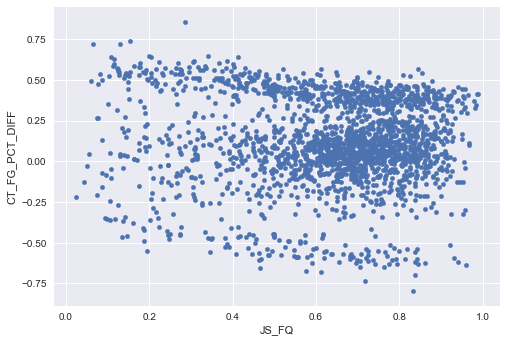

In [150]:
cur_col = 'JS_FQ'

a = df[df[cur_col]>0]
a = a[a[cur_col] < 1]
a = a[a['CT_FG_PCT'] != -1]
a.plot(kind = 'scatter', x = cur_col, y='CT_FG_PCT_DIFF')

In [152]:
a[a['CT_FG_PCT_DIFF'] > 0.25]

,FG_PCT,FG3_PCT,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,...,AOP_FQ,Bank_FQ,DUNK_FQ,FADE_FQ,FGR_FQ,HOOK_FQ,JS_FQ,LAY_FQ,TIP_FQ,CT_FG_PCT_DIFF
26,0.459000,0.300000,0.784000,1.200000,3.300000,4.400000,1.000000,0.900000,0.400000,0.300000,...,0.003021,0.009063,0.105740,0.012085,0.009063,0.039275,0.658610,0.181269,0.021148,0.459000
28,0.377000,0.329333,0.723667,0.466667,2.100000,2.533333,0.366667,0.500000,0.266667,0.300000,...,0.005882,0.005882,0.035294,0.023529,0.011765,0.029412,0.676471,0.247059,0.035294,0.377000
31,0.407000,0.400000,0.609000,0.300000,0.600000,0.900000,0.500000,0.500000,0.500000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.709302,0.267442,0.023256,0.407000
33,0.503000,0.000000,0.581000,1.800000,2.300000,4.100000,0.500000,0.900000,0.500000,0.700000,...,0.010811,0.005405,0.162162,0.000000,0.005405,0.172973,0.194595,0.356757,0.124324,0.503000
34,0.544000,0.000000,0.502000,2.800000,4.600000,7.500000,0.900000,1.400000,0.500000,1.200000,...,0.032581,0.025063,0.213033,0.000000,0.010025,0.230576,0.190476,0.300752,0.077694,0.544000
42,0.432000,0.000000,0.579000,1.400000,3.200000,4.500000,0.900000,0.500000,0.200000,0.500000,...,0.000000,0.022727,0.068182,0.045455,0.000000,0.022727,0.431818,0.454545,0.000000,0.432000
66,0.500000,0.000000,0.725000,1.200000,3.400000,4.500000,0.300000,0.800000,0.500000,0.600000,...,0.005618,0.022472,0.129213,0.022472,0.011236,0.073034,0.533708,0.235955,0.033708,0.500000
70,0.513000,0.000000,0.481000,1.900000,2.400000,4.300000,0.700000,0.400000,0.400000,0.400000,...,0.000000,0.012821,0.128205,0.000000,0.000000,0.000000,0.358974,0.307692,0.205128,0.513000
73,0.551000,0.000000,0.590333,0.766667,2.166667,2.933333,0.200000,0.533333,0.100000,0.566667,...,0.000000,0.037500,0.250000,0.000000,0.012500,0.237500,0.275000,0.250000,0.075000,0.551000
77,0.523000,0.000000,0.682000,0.800000,1.700000,2.500000,0.400000,0.300000,0.400000,0.400000,...,0.000000,0.011628,0.127907,0.000000,0.023256,0.279070,0.151163,0.441860,0.046512,0.523000
